In [1]:
"""General methyl data import using MSM package. General dictonary data, beta value methylation array df, survival metadata df"""

import sys
sys.path.insert(0, '/Users/zacksiegfried/Documents/methylspan')
import MSM

all_files = MSM.pullMethylMetaData('pancreas')

# not gaureteed to return same number of cases, (remove file_id from sample data if missing from meta data)
# missing values dropped anyways in next steps
sample_data = MSM.methylDataFormat(all_files, 471)
meta_data = MSM.metaDataFormat(sample_data, all_files)



Number of methylation files for all cases for primary site pancreas: 471
Final number of cases in methylation dataset : 435
Final number of cases in metadata dataset : 426


In [8]:
### FORMATTING FOR SURVIVAL + PCA

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# drops all CpG sites with at least 1 missing value
sample_data.index.name = 'id'
sample_data.dropna(axis=1, inplace=True)

# standardizes dataframe
scaled_df = sample_data.copy()
scaled_df = pd.DataFrame(StandardScaler().fit_transform(scaled_df), index=scaled_df.index, columns=scaled_df.columns)

print(scaled_df.shape)

# converts CpG sites to PCA components
pca = PCA(n_components=15)      # setting number of PCAs to 15
pca.fit(scaled_df)

output = pca.transform(scaled_df)
x = pd.DataFrame(output, index=scaled_df.index)

meta_data.index.name = 'id'

# merges dfs and formats 
full_data = pd.merge(meta_data, x, on = 'id')
full_data.replace(['Dead', 'Alive'],[1, 0], inplace=True)
full_data = full_data[full_data['days_to_death'].notna()]

print(full_data.shape)

(435, 272906)
(400, 17)


In [9]:
### SURVIVAL ANALYSIS EXECUTION & TESTING

from lifelines import CoxPHFitter
from lifelines.calibration import survival_probability_calibration
from lifelines.utils import k_fold_cross_validation

cph = CoxPHFitter()
cph.fit(full_data, duration_col='days_to_death', event_col='vital_status')

print(cph.confidence_intervals_)
print(cph.concordance_index_)
print(cph.check_assumptions(full_data))

cph.print_summary()

# Predictions (will remodel cph.)
#scores = k_fold_cross_validation(cph, full_data, 'days_to_death', event_col='vital_status', k=5, scoring_method="concordance_index")
#print(scores)

           95% lower-bound  95% upper-bound
covariate                                  
0                 0.000885         0.002613
1                -0.003341        -0.000926
2                -0.005146        -0.000644
3                 0.000471         0.003127
4                -0.001719         0.000672
5                -0.008481        -0.001343
6                -0.000607         0.002502
7                -0.008452        -0.000436
8                -0.001819         0.002325
9                -0.005807        -0.000211
10               -0.002088         0.002497
11               -0.001123         0.004227
12               -0.014413        -0.004726
13               -0.002455         0.003271
14               -0.004192         0.006276
0.6508142281259435
Proportional hazard assumption looks okay.
[]


/Users/zacksiegfried/opt/anaconda3/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1266: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  self.params_ = pd.Series(params_, index=pd.Index(X.columns, name="covariate"), name="coef")


<lifelines.CoxPHFitter: fitted with 400 total observations, 135 right-censored observations>
             duration col = 'days_to_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 400
number of events observed = 265
   partial log-likelihood = -1319.96
         time fit was run = 2023-04-16 01:57:38 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
0           0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
1          -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
2          -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
3           0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
4          -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
5          -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
6           0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
7          -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
8           0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
9          -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
10          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
11          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
12         -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
13          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
14          0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01

            cmp to     z      p   -log2(p)
covariate                                 
0             0.00  3.97 <0.005      13.75
1             0.00 -3.46 <0.005      10.87
2             0.00 -2.52   0.01       6.42
3             0.00  2.65   0.01       6.98
4             0.00 -0.86   0.39       1.36
5             0.00 -2.70   0.01       7.16
6             0.00  1.19   0.23       2.11
7             0.00 -2.17   0.03       5.07
8             0.00  0.24   0.81       0.30
9             0.00 -2.11   0.04       4.83
10            0.00  0.18   0.86       0.22
11            0.00  1.14   0.26       1.97
12            0.00 -3.87 <0.005      13.18
13            0.00  0.28   0.78       0.36
14            0.00  0.39   0.70       0.52
---
Concordance = 0.65
Partial AIC = 2669.93
log-likelihood ratio test = 86.14 on 15 df
-log2(p) of ll-ratio test = 37.49

/Users/zacksiegfried/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='days_to_death', ylabel='deviance'>

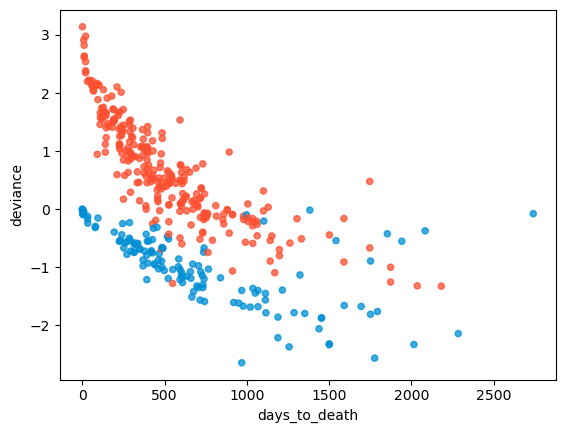

In [7]:
# predictive performance
import numpy as np

r = cph.compute_residuals(full_data, 'deviance')

r.plot.scatter(
    x='days_to_death', y='deviance', c=np.where(r['vital_status'], '#fc4f30', '#008fd5'),
    alpha=0.75
)




In [10]:
cph.predict(full_data)

AttributeError: CoxPHFitter has no attribute 'predict'